# ERCOT Load Model

*Adapted from Dr. David Chassin's Aggregate Building Load Model*

Olin Shipstead

## Importing data

In [1]:
from datetime import *
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 
import re

In [2]:
# ------ IMPORTING LOAD DATA --------- #
# Source: http://www.ercot.com/gridinfo/load/load_hist
# using ERCOT's Southern Load Zone

def fix_time(x):
    m, d, y, h, mn = map(int, re.findall('\d+', str(x["Hour Ending"])))
    return datetime(y,m,d,h-1,mn)

load = pd.read_excel("ERCOT_Native_Load_2021.xlsx")

load["timestamp"] = load.apply(fix_time, axis=1)
load = load.filter(["timestamp","SOUTH"]).rename(columns={"SOUTH":"Load"}).set_index("timestamp") # focusing on SOUTH as this is where we have solar data
load.head()

,Load
timestamp,
2021-01-01 00:00:00,3545.093310
2021-01-01 01:00:00,3586.547882
2021-01-01 02:00:00,3586.124059
2021-01-01 03:00:00,3570.592369
2021-01-01 04:00:00,3590.902242


In [3]:
# ------ IMPORTING SOLAR+TEMP DATA ------ #
# Source: University of Texas Panamerican Solar Radiation Lab (https://midcdmz.nrel.gov/apps/daily.pl?site=UTPASRL&start=20110901&yr=2021&mo=11&dy=15)
# solar data is complete, but temp data only goes back to 02/08/2021
#! note - weather data complete from 02/08/2021 to mid-May 2021

weather = pd.read_csv("UT-PanAmerican_Solar_Temp.txt",sep=",", na_values=-99999).dropna()
weather["timestamp"] = weather.apply(lambda x: datetime.strptime(str(x["DATE (MM/DD/YYYY)"])+" "+str(x["HOUR-CST"]),"%m/%d/%Y %H"), axis=1)
weather = weather.filter(["timestamp","Avg Global Horizontal [W/m^2]","Avg Air Temperature [deg C]"])\
    .rename(columns={"Avg Global Horizontal [W/m^2]":"Solar","Avg Air Temperature [deg C]":"Temp"})\
    .set_index("timestamp")
weather.head()
#! problem due to data avail?

,Solar,Temp
timestamp,,
2021-02-08 17:00:00,197.9478,26.6153
2021-02-08 18:00:00,58.8003,26.2997
2021-02-08 19:00:00,3.9165,25.4203
2021-02-08 20:00:00,-1.6885,23.6561
2021-02-08 21:00:00,-1.6887,23.1087


In [4]:
# ------ IMPORTING PRICE DATA ------ #
# Source: https://sa.ercot.com/misapp/GetReports.do?reportTypeId=13061&reportTitle=Historical%20RTM%20Load%20Zone%20and%20Hub%20Prices&showHTMLView=&mimicKey
# data represents Historical RTM Load Zone and Hub Prices

price = pd.read_excel("Feb21_LZ_SOUTH_Prices.xlsx", sheet_name="Feb")

price["timestamp"] = price.apply(lambda x: datetime.strptime(\
                                        str(x["Delivery Date"])+" "+\
                                        str(x["Delivery Hour"]-1)+":"+\
                                        str((x["Delivery Interval"]-1)*15),\
                                       "%m/%d/%Y %H:%M"),\
                                        axis=1)
price = price.filter(["timestamp","Settlement Point Price"])\
    .rename(columns={"Settlement Point Price":"Price"}).set_index("timestamp")
price.head()

,Price
timestamp,
2021-02-01 00:00:00,12.05
2021-02-01 00:15:00,11.32
2021-02-01 00:30:00,9.35
2021-02-01 00:45:00,7.35
2021-02-01 01:00:00,8.30


## Merging and interpolating data to 15-min intervals

In [5]:
start = "2021-02-08 17:00:00" # constrained by weather (solar)
end = "2021-02-28 23:00:00"   # constrained by price
load_df = price.join(weather).join(load)[start:end].interpolate(method="linear") # interpolates solar, temp, load
print(f"Number of observations: {len(load_df)}")
load_df.head()

Number of observations: 1945


,Price,Solar,Temp,Load
timestamp,,,,
2021-02-08 17:00:00,20.25,197.947800,26.6153,3340.425916
2021-02-08 17:15:00,21.56,163.160925,26.5364,3338.721461
2021-02-08 17:30:00,23.94,128.374050,26.4575,3337.017006
2021-02-08 17:45:00,26.66,93.587175,26.3786,3335.312551
2021-02-08 18:00:00,27.69,58.800300,26.2997,3333.608096


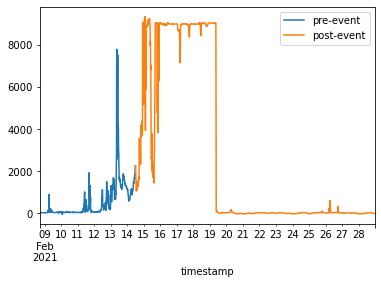

In [6]:
# define event timestamp to be midday 02-14
event = "02-14-2021 12:00:00"
load_df.Price[:event].plot(label="pre-event",legend=True)
load_df.Price[event:].plot(label="post-event",legend=True);

## Define transfer function

The $z$-domain transfer function from $T_O$ to $P$ can be written as
$$
    { P(z) \over T(z) } = { b_0 + b_1 z^{-1} + b_2 z^{-2} \over 1 + a_1 z^{-1} + a_2 z^{-2}+ a_3 z^{-3} }
$$
which gives us the relation
$$
    \mathbf{P}_{t} = 
        + b_2 \mathbf{T}_{t-2} 
        + b_1 \mathbf{T}_{t-1} 
        + b_0 \mathbf{T}_{t} 
        - a_3 \mathbf{P}_{t-3} 
        - a_2 \mathbf{P}_{t-2} 
        - a_1 \mathbf{P}_{t-1}
$$
where $t \in (4,K)$, and $\mathbf P$ and $\mathbf T \in \mathbb{R}^{K}$.

Given $K$ samples of power and temperature, this can be written in the form
$$
    \mathbf{M} \mathbf{x} = \mathbf{P}_{t}
$$
where $\mathbf{M} \in \mathbb{R}^{K-3\times6}$ with
$$
    \mathbf{M} = \left[ \begin{matrix} \mathbf{P}_{t-3} & \mathbf{P}_{t-2} & \mathbf{P}_{t-1} & \mathbf{T}_{t-2} & \mathbf{T}_{t-1} & \mathbf{T}_{t} \end{matrix} \right]
$$
and
$$
    \mathbf{x} = \left[ \begin{matrix} b_2 & b_1 & b_0 & -a_2 & -a_1 & -a_0 \end{matrix} \right]^T
$$
Solve for $\mathbf x$.
$$
    \mathbf{x} = (\mathbf{M}^T \mathbf{M})^{-1} \mathbf{M}^T \mathbf{P}_{t}.
$$

This solution can also be obtained efficiently using the Python SciPy `linalg.solve` function.


## Solve for transfer function coefficients

In [7]:
R = 3 # order of model 
K = len(load_df.Price) # num observations
N = len(load_df.Price[event:]) # observations to hold out

L = np.matrix(load_df.Load).transpose()  # load
T = np.matrix(load_df.Temp).transpose()  # temp
S = np.matrix(load_df.Solar).transpose() # solar
P = np.matrix(load_df.Price).transpose() # price

# construct M matrix
M = np.hstack([np.hstack([L[n:K-R+n] for n in range(R)]),
            np.hstack([T[n+1:K-R+n+1] for n in range(R)]),
            np.hstack([S[n+1:K-R+n+1] for n in range(R)]),
            np.hstack([P[n+1:K-R+n+1] for n in range(R)])])
print(M.shape)

Mh = M[0:-N] # leaving out last N observations
Mt = Mh.transpose()
x = np.linalg.solve(np.matmul(Mt,Mh),np.matmul(Mt,L[R:-N]))
Q = M[-N:]*x # predicted power output

(1942, 12)


## Visualize results

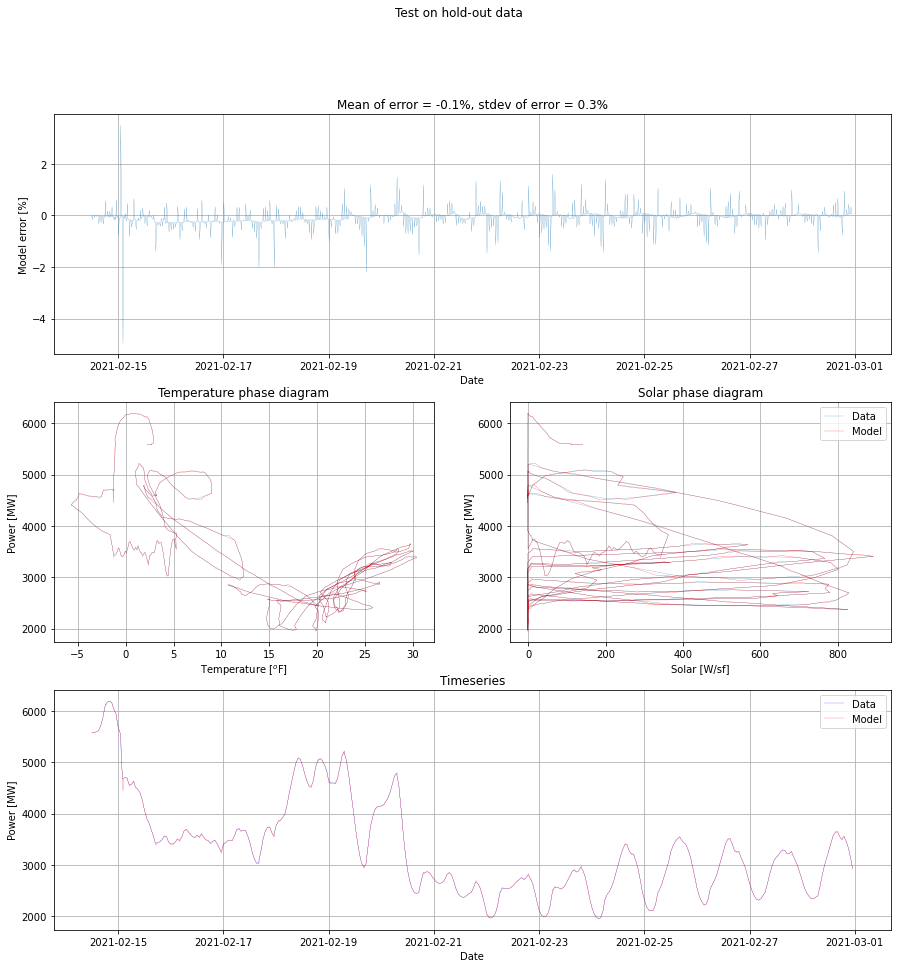

In [8]:
plt.figure(1,figsize=(15,15))

plt.suptitle(f"Test on hold-out data")

plt.subplot(311)
e = Q/L[-N:]-1 
t = load_df.index
plt.plot(t[-N:],e*100,linewidth=0.2)
plt.grid()
plt.xlabel("Date")
plt.ylabel("Model error [%]")
plt.title(f'Mean of error = {e.mean()*100:.1f}%, stdev of error = {e.std()*100:.1f}%')

plt.subplot(323)
plt.plot(T[-N:],load_df.Load[-N:],linewidth=0.2,label="Data")
plt.plot(T[-N:],Q,'-r',linewidth=0.2,label="Model")
plt.grid()
plt.xlabel('Temperature [$^o$F]')
plt.ylabel('Power [MW]')
plt.title("Temperature phase diagram")

plt.subplot(324)
plt.plot(S[-N:],load_df.Load[-N:],linewidth=0.2,label="Data")
plt.plot(S[-N:],Q,'-r',linewidth=0.2,label="Model")
plt.grid()
plt.xlabel('Solar [W/sf]')
plt.ylabel('Power [MW]')
plt.title("Solar phase diagram")
plt.legend()

plt.subplot(313)
plt.plot(t[-N:],L[-N:],'-b',linewidth=0.2,label="Data")
plt.plot(t[-N:],Q,'-r',linewidth=0.2,label="Model")
plt.grid()
plt.xlabel('Date')
plt.ylabel('Power [MW]')
plt.legend()
plt.title("Timeseries");

In [9]:
from dateutil import *
from csv import *

# power data helper functions
def power(x):
    try:
        return round(float(x),1)
    except:
        return float('NAN')

def timestamp(x):
    return datetime.strptime(x,"%m/%d/%y %H:%M")

In [10]:
# import power data (Portland)
feeder_power = pd.read_csv("portland_feeder_power.csv",
                       converters={
                           "timestamp":timestamp,
                           "feeder_power":power,
                       })

In [11]:
feeder_power

,timestamp,power
0,2014-10-01 00:00:00,1798.85
1,2014-10-01 00:05:00,1782.63
2,2014-10-01 00:10:00,1766.58
3,2014-10-01 00:15:00,1768.91
4,2014-10-01 00:20:00,1756.20
...,...,...
315643,2017-09-30 23:35:00,1778.38
315644,2017-09-30 23:40:00,1762.14
315645,2017-09-30 23:45:00,1754.48
315646,2017-09-30 23:50:00,1741.93


In [12]:
index = list(map(lambda t:datetime(t.year,t.month,t.day,t.hour),pd.DatetimeIndex(feeder_power.timestamp)))
power = feeder_power.groupby(index).power.mean()

In [13]:
# weather helper functions
def temperature(x):
    try:
        return round(float(x),1)
    except:
        return float('NAN')
def solar(x):
    try:
        return round(float(x),1)
    except:
        return float('NAN')

def from_datetime(x):
    return datetime.strptime(x,"%Y-%m-%d %H:%M:%S")

In [14]:
# import weather data
feeder_weather = pd.read_csv("portland_feeder_weather.csv",
                    converters={
                      "datetime":from_datetime,
                      "heat_index[degF]":temperature,
                      "solar_global[W/sf]":solar,
                    },
                    usecols = ["datetime","solar_global[W/sf]","heat_index[degF]"],
                    keep_default_na = False,
                    index_col = ["datetime"])
feeder_weather

,solar_global[W/sf],heat_index[degF]
datetime,,
2014-01-01 00:00:00,0.0,40.2
2014-01-01 01:00:00,0.0,38.4
2014-01-01 02:00:00,0.0,36.5
2014-01-01 03:00:00,0.0,36.5
2014-01-01 04:00:00,0.0,36.5
...,...,...
2017-12-31 19:00:00,0.0,32.7
2017-12-31 20:00:00,0.0,32.7
2017-12-31 21:00:00,0.0,32.7


<AxesSubplot:xlabel='datetime'>

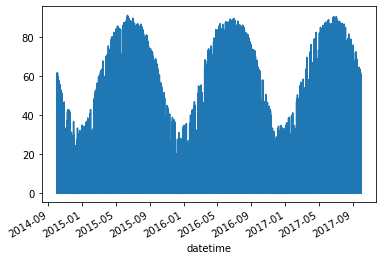

In [15]:
# join weather and power data
index = list(map(lambda t:datetime(t.year,t.month,t.day,t.hour),feeder_weather.index))
feeder = feeder_weather.groupby(index).mean().join(power.round(1)).dropna()
feeder.columns = ["solar","temperature","power"]
feeder.index.name = "datetime"
feeder.solar.plot()

### Transfer function

The $z$-domain transfer function from $T_O$ to $P$ can be written as
$$
    { P(z) \over T(z) } = { b_0 + b_1 z^{-1} + b_2 z^{-2} \over 1 + a_1 z^{-1} + a_2 z^{-2}+ a_3 z^{-3} }
$$
which gives us the relation
$$
    \mathbf{P}_{t} = 
        + b_2 \mathbf{T}_{t-2} 
        + b_1 \mathbf{T}_{t-1} 
        + b_0 \mathbf{T}_{t} 
        - a_3 \mathbf{P}_{t-3} 
        - a_2 \mathbf{P}_{t-2} 
        - a_1 \mathbf{P}_{t-1}
$$
where $t \in (4,K)$, and $\mathbf P$ and $\mathbf T \in \mathbb{R}^{K}$.

Given $K$ samples of power and temperature, this can be written in the form
$$
    \mathbf{M} \mathbf{x} = \mathbf{P}_{t}
$$
where $\mathbf{M} \in \mathbb{R}^{K-3\times6}$ with
$$
    \mathbf{M} = \left[ \begin{matrix} \mathbf{P}_{t-3} & \mathbf{P}_{t-2} & \mathbf{P}_{t-1} & \mathbf{T}_{t-2} & \mathbf{T}_{t-1} & \mathbf{T}_{t} \end{matrix} \right]
$$
and
$$
    \mathbf{x} = \left[ \begin{matrix} b_2 & b_1 & b_0 & -a_2 & -a_1 & -a_0 \end{matrix} \right]^T
$$
Solve for $\mathbf x$.
$$
    \mathbf{x} = (\mathbf{M}^T \mathbf{M})^{-1} \mathbf{M}^T \mathbf{P}_{t}.
$$

This solution can also be obtained efficiently using the Python SciPy `linalg.solve` function.


In [16]:
L = 3 # order of model 
K = len(feeder.power) # hours of observation
N = int(8760/12) # hours of data to hold out

P = np.matrix(feeder.power).transpose()
T = np.matrix(feeder.temperature).transpose()
S = np.matrix(feeder.solar).transpose()

# construct M matrix
M = np.hstack([np.hstack([P[n:K-L+n] for n in range(L)]),
            np.hstack([T[n+1:K-L+n+1] for n in range(L)]),
            np.hstack([S[n+1:K-L+n+1] for n in range(L)])])
print(M.shape)

Mh = M[0:-N] # leaving out last N observations
Mt = Mh.transpose()
x = np.linalg.solve(np.matmul(Mt,Mh),np.matmul(Mt,P[L:-N]))
Q = M[-N:]*x # predicted power output

(26185, 9)


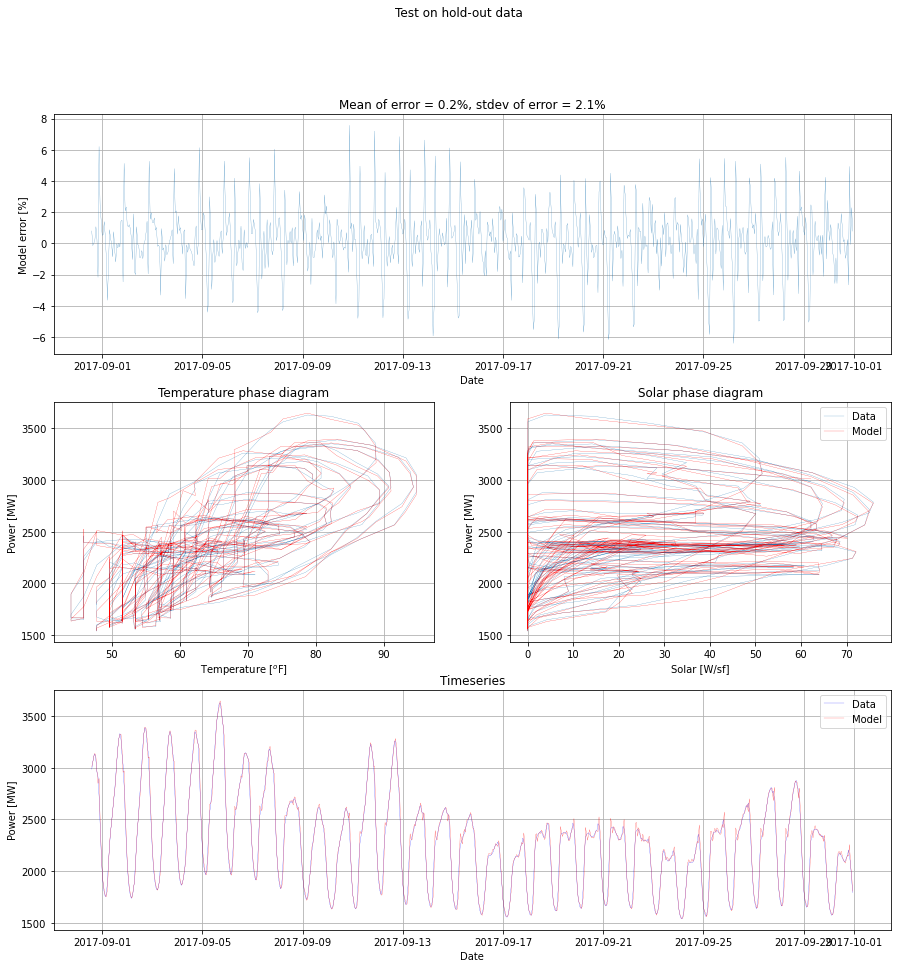

In [17]:
plt.figure(1,figsize=(15,15))

plt.suptitle(f"Test on hold-out data")

plt.subplot(311)
e = Q/P[-N:]-1 
t = feeder.index
plt.plot(t[-N:],e*100,linewidth=0.2)
plt.grid()
plt.xlabel("Date")
plt.ylabel("Model error [%]")
plt.title(f'Mean of error = {e.mean()*100:.1f}%, stdev of error = {e.std()*100:.1f}%')

plt.subplot(323)
plt.plot(T[-N:],feeder.power[-N:],linewidth=0.2,label="Data")
plt.plot(T[-N:],Q,'-r',linewidth=0.2,label="Model")
plt.grid()
plt.xlabel('Temperature [$^o$F]')
plt.ylabel('Power [MW]')
plt.title("Temperature phase diagram")

plt.subplot(324)
plt.plot(S[-N:],feeder.power[-N:],linewidth=0.2,label="Data")
plt.plot(S[-N:],Q,'-r',linewidth=0.2,label="Model")
plt.grid()
plt.xlabel('Solar [W/sf]')
plt.ylabel('Power [MW]')
plt.title("Solar phase diagram")
plt.legend()

plt.subplot(313)
plt.plot(t[-N:],P[-N:],'-b',linewidth=0.2,label="Data")
plt.plot(t[-N:],Q,'-r',linewidth=0.2,label="Model")
plt.grid()
plt.xlabel('Date')
plt.ylabel('Power [MW]')
plt.legend()
plt.title("Timeseries");

___